<a href="https://colab.research.google.com/github/TishaJeswani/codsoft_task3-level1-/blob/master/Model_based_collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#E-commerce Product recommendation System

##Importing libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

## Importing Dataset

In [ ]:
#Import the data set
df = pd.read_csv('/content/ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

## EDA - Exploratory Data Analysis

check for -
- shape
- datatype
- missing values


finally get the summary and check
- rating distribution.
- number of users and products.
- Users with highest no of ratings.

### Shape

In [ ]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  927109
No of columns =  3


### Datatypes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927109 entries, 0 to 927108
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  927109 non-null  object 
 1   prod_id  927109 non-null  object 
 2   rating   927109 non-null  float64
dtypes: float64(1), object(2)
memory usage: 21.2+ MB


### Missing value analysis

In [ ]:
# Find number of missing values in each column
df.isna().sum()

,0
user_id,0
prod_id,0
rating,0


### Summary

In [ ]:
# Summary statistics of 'rating' variable
df['rating'].describe()

,rating
count,927109.000000
mean,3.977244
std,1.398075
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


### Rating distribution

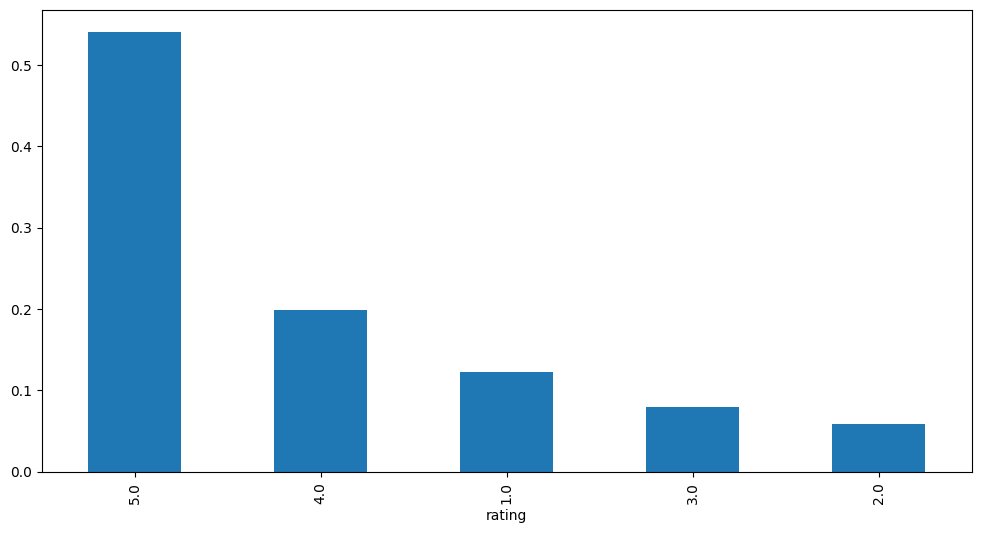

In [ ]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  706107
Number of unique ITEMS in Raw data =  54561


### Users with most no of rating

In [ ]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

,0
user_id,
A5JLAU2ARJ0BO,403
A231WM2Z2JL0U3,249
A25HBO5V8S8SEA,163
A6FIAB28IS79,133
AKT8TGIT6VVZ5,120
AT6CZDCP4TRGA,119
A11D1KHM7DVOQK,107
A2B7BUH8834Y6M,100
A2R6RA8FRBS608,88


## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [ ]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [ ]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 3079
Number of unique USERS in the final data =  34
Number of unique PRODUCTS in the final data =  2628


- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

### Checking the density of the rating matrix

In [ ]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (34, 2628)
given_num_of_ratings =  3079
possible_num_of_ratings =  89352
density: 3.45%


prod_id,1400532655,9043413585,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,...,B000F9YN22,B000FAPQHM,B000FBS3US,B000FCHTCK,B000FCJUNG,B000FCP4ZY,B000FCSXBQ,B000FD8MJS,B000FD9N0K,B000FDTNZK
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1435P5AMCPB3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1F9Z42CFF9IAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## CSR matrix

In [ ]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)


## SVD

In [ ]:
# Check the shape of the matrix
rows, cols = final_ratings_sparse.shape
k = min(rows, cols) - 1  # Set k to be less than the smallest dimension

# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k=k)

# Construct diagonal array in SVD
sigma = np.diag(s)


In [ ]:
U.shape

(1540, 50)

In [ ]:
sigma.shape

(50, 50)

In [ ]:
Vt.shape

(50, 48190)

Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

## Predicting ratings

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

## Function to recommend products

In [ ]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):

    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]

    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


### Recommending top 5 products to user id 121

In [ ]:
# Check the number of users
num_users = final_ratings_sparse.shape[0]
print(f"Number of users: {num_users}")

# If user 121 does not exist, pick another valid user index
valid_user_index = min(121, num_users - 1)

# Enter valid user index for recommendations
recommend_items(valid_user_index, final_ratings_sparse, preds_matrix, 5)


Number of users: 34

Below are the recommended products for user(user_id = 33):

Recommended Products
1491    0.030562
1472    0.022749
1165    0.022058
1353    0.022058
1075    0.022058
Name: user_predictions, dtype: float64


## Evaluating the model

In [ ]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,1400532655,9043413585,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,...,B000F9YN22,B000FAPQHM,B000FBS3US,B000FCHTCK,B000FCJUNG,B000FCP4ZY,B000FCSXBQ,B000FD8MJS,B000FD9N0K,B000FDTNZK
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

,0
prod_id,
1400532655,0.029412
9043413585,0.088235
B000000O48,0.147059
B000001OL6,0.117647
B000001OMI,0.147059


In [ ]:
preds_df.head()

prod_id,1400532655,9043413585,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,...,B000F9YN22,B000FAPQHM,B000FBS3US,B000FCHTCK,B000FCJUNG,B000FCP4ZY,B000FCSXBQ,B000FD8MJS,B000FD9N0K,B000FDTNZK
0,0.000051,0.000084,0.000178,0.000064,0.000151,1.999953,0.000187,0.001504,0.000267,0.000036,...,0.000738,0.000066,0.000096,0.000203,0.000249,0.000064,0.000249,0.001203,0.000249,0.000020
1,0.005267,0.008713,0.018461,0.006684,0.015664,0.004937,0.019396,0.156342,0.027803,0.003692,...,0.076695,0.006904,0.009942,0.021070,0.025862,0.006684,0.025862,0.125073,0.025862,0.002060
2,0.004196,0.006941,0.014707,0.005325,0.012479,0.003933,0.015452,0.124552,0.022150,0.002941,...,0.061101,0.005500,0.007920,0.016786,0.020603,0.005325,0.020603,0.099642,0.020603,0.001641
3,0.000640,0.001059,0.002243,0.000812,0.001903,0.000600,0.002357,0.018995,0.003378,0.000449,...,0.009318,0.000839,0.001208,0.002560,0.003142,0.000812,0.003142,0.015196,0.003142,0.000250
4,0.000203,0.000336,0.000711,0.000258,0.000604,0.000190,0.000747,0.006024,0.001071,0.000142,...,0.002955,0.000266,0.000383,0.000812,0.000997,0.000258,0.000997,0.004819,0.000997,0.000079


In [ ]:
avg_preds=preds_df.mean()
avg_preds.head()

,0
prod_id,
1400532655,0.030175
9043413585,0.089502
B000000O48,0.149739
B000001OL6,0.118620
B000001OMI,0.149335


In [ ]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
prod_id,,
0594451647,0.003247,0.003360
0594481813,0.001948,0.005729
0970407998,0.003247,0.008566
0972683275,0.012338,0.035330
1400501466,0.012987,0.006966


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_rmse(interactions_matrix, preds_matrix):
    # Get the non-zero elements in the interaction matrix (i.e., where actual ratings exist)
    non_zero_indices = interactions_matrix.nonzero()

    # Get the actual ratings and predicted ratings directly
    actual_ratings = interactions_matrix[non_zero_indices].A1  # .A1 converts sparse matrix to 1D array
    predicted_ratings = preds_matrix[non_zero_indices].A1      # .A1 for predicted sparse matrix

    # Compute RMSE
    mse = mean_squared_error(actual_ratings, predicted_ratings)
    rmse = np.sqrt(mse)
    return rmse

rmse_value = calculate_rmse(final_ratings_sparse, preds_matrix)
print(f"RMSE: {rmse_value}")


RMSE: 0.269534061030828


In [ ]:
# Check the number of users
num_users = final_ratings_sparse.shape[0]
print(f"Number of users: {num_users}")

# Adjust user index if it's out of range
if user_index >= num_users:
    print(f"User index {user_index} is out of range. Using max valid user index {num_users - 1}.")
    user_index = num_users - 1  # Set to the maximum valid user index

# Calculate Precision@K and Recall@K
precision = precision_at_k(user_index, final_ratings_sparse, preds_matrix, k=10)
recall = recall_at_k(user_index, final_ratings_sparse, preds_matrix, k=10)

print(f"Precision@5 for user {user_index}: {precision}")
print(f"Recall@5 for user {user_index}: {recall}")


Number of users: 34
Precision@5 for user 33: 1.0
Recall@5 for user 33: 0.17857142857142858
